In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

**Comments not up to date yet**

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)$$ with parameters $$ \mu_X \text{ and } \sigma_X \text{fixed but unknown.} $$ We will use a transformation such that $$ T(u)  = A.u + b $$


In [76]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N_test = 10*N
prior = torch.distributions.Normal(loc=torch.Tensor([0.0]), scale=torch.Tensor([1.0]))


def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """  
    #Generating observations from the true distribution
    X = torch.distributions.Normal(loc=mu_x,scale=sigma_x).sample((number_of_observations, ))
    return X
X=gen_observations(N)
X_test = gen_observations(N_test)

In [77]:

class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
        
    """
    
    def __init__(self, alpha, b, prior):
        """Init the linear transformer u -> Au +b 

        Args:
            alpha (Float): log(weight)
            b (Float): biais
            prior (torch.distributions): Prior simple to sample from e.g. Normal
        """
        super(T, self).__init__()
        self.b = nn.Parameter(torch.Tensor([b]), requires_grad=True)
        self.alpha = nn.Parameter(torch.Tensor([alpha]), requires_grad=True)
        self.prior = prior
    
    def forward(self,x:torch.tensor):
        """Compute the linear transformation Ax + b

        Args:
            x (torch.tensor)

        Returns:
            torch.tensor A*x + b and log(detJ) = alpha
        """
        
        z = torch.exp(self.alpha) * x + self.b
        return z,self.alpha

    def reverse(self,x):
        """Apply the reverse transformation x -> u = (x-b)/exp(alpha)

        Args:
            x (torch.Tensor)

        Returns:
            Tuple: u, log(det(J^-1)) = -alpha
        """
        return (x-self.b)/(torch.exp(self.alpha)), -self.alpha
    
    def L(self, x): 
        """Compute the loss (forward KL-D)

        Args:
            x (torch.Tensor)

        Returns:
            float
        """

        u, logdet_J = self.reverse(x)
        logprob = self.prior.log_prob(u)
        res =  logdet_J + logprob
        return  -res.mean() #To minimise
    
    def sample(self, size : tuple):
        """Generates U from the prior and returns T(u)

        Args:
            size (tuple): Size of the desired sample. Must be a tuple

        Returns:
            torch.Tensor
        """
        U = self.prior.sample(size)
        z = self.forward(U)[0]
        return z

In [78]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation 
learning_rate = 1e-3
#optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [79]:
# Keeping records of these values for later visualisations
losses_train = []
estimated_A = []
estimated_b = []

stable_loss = False
epsilon = 1e-5 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = transformation.L(X_test).mean().detach().item()
    
for i in range(n_iter):
    
    #Computing train loss
    loss_train = transformation.L(X)
    losses_train.append(loss_train.detach().item())
    
    #Optimizaton steps
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    #Keeping records of the estimated parameters
    A_hat, b_hat = torch.exp(transformation.alpha).detach().item(), transformation.b.detach().item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    if i%500 == 0:
        print(f"Iter {i}, loss = {loss_train}")
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss: #If the loss of the test sample is 'close to' the last one computed
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Iter 0, loss = 2.2027664184570312
Iter 500, loss = 1.8510568141937256
Iter 1000, loss = 1.3873088359832764
Iter 1500, loss = 0.8318953514099121
Iter 2000, loss = 0.7109503746032715
Early stop at iteration 2100


In [80]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1] 
sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=False)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final training loss = ", losses_train[-1])

 Sample mean = 2.9879324436187744 and b_hat =  2.985535144805908
 Sample std = 0.4925100803375244 and A_hat =  0.4951411783695221
 Final training loss =  0.7107389569282532


As expected, the estimated expectation (resp. standard deviation) converges to the sample expectation (resp. standard deviation)

## Visualisation

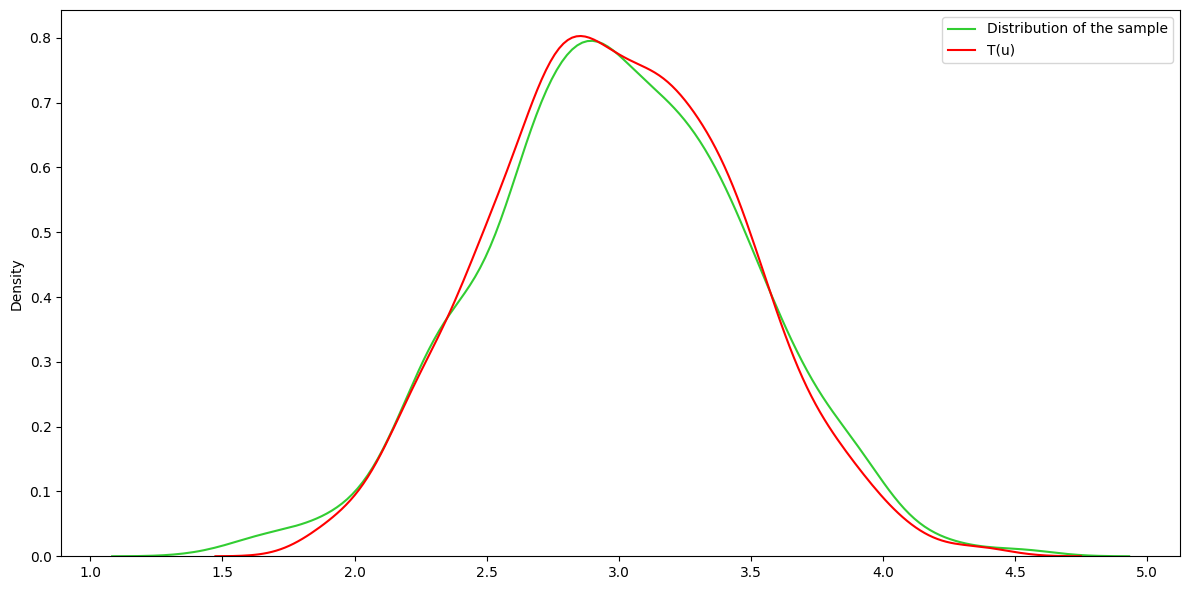

In [81]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.sample( (N , )).detach().squeeze(), ax = ax, color='red', label='T(u)')

#sns.histplot(data=X.squeeze(), stat='density', kde=False, ax=ax, color='limegreen', alpha=0.3, bins=30)
#sns.histplot(data=transformation.sample((N,)).detach().squeeze(), stat='density', kde=False, ax=ax, color='red', alpha=0.3, bins=30)

ax.legend()
plt.tight_layout()
plt.show()

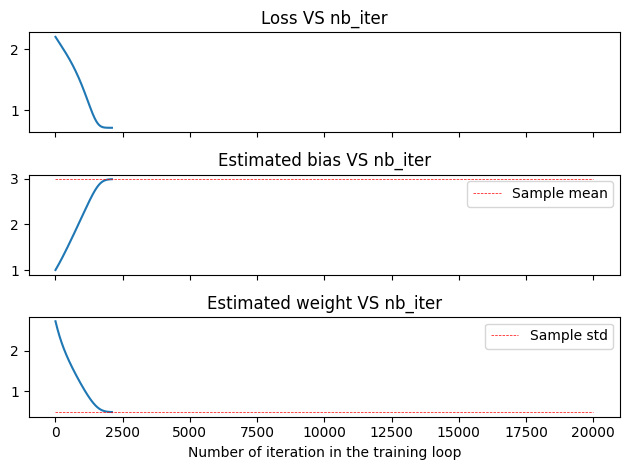

In [82]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].legend()
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated weight VS nb_iter")
plt.xlabel("Number of iteration in the training loop")
fig.tight_layout()

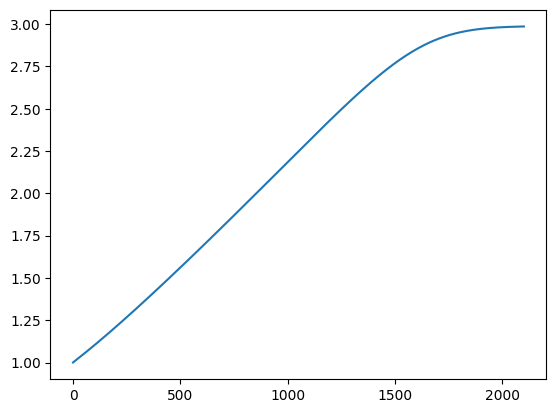

In [83]:
plt.plot(estimated_b)

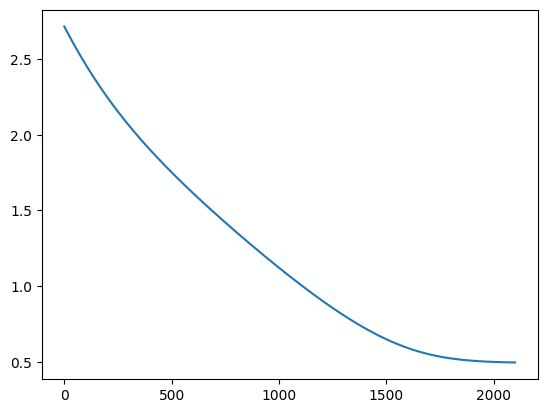

In [84]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [85]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses_train[-1] # Pas grande différence avec la final loss sur le train

tensor(0.7208)


0.7107389569282532

## Effect of sample size

In [86]:
n_iter = 20000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
learning_rate = 1e-3
optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [87]:
sample_sizes = []
estimated_A_avg = []
estimated_b_avg = []
sample_mean_avg = []
sample_sigma_avg = []
n_iter = 20000
for sample_size in range(10,1000,50): #Size of the observed data
    print(f" Sample size = {sample_size}")
    sample_sizes.append(sample_size) #Saving for later plots

    current_size_A_hat = []
    current_size_b_hat = []
    current_size_sample_mean = []
    current_size_sample_sigma = []
    
    for k in range(10): #We generates observed data 10 times to diminish the randomness, esp. with a small sample size
        X = gen_observations(sample_size)
        X_test = gen_observations(sample_size)
        transformer =T(1, 1, torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0])))
        learning_rate = 1e-3
        optimizer = torch.optim.SGD(transformer.parameters(), learning_rate)
        stable_loss = False
        epsilon = 1e-4
        with torch.no_grad():
            previous_loss_test = transformer.L(X_test).mean().detach().item()
        for i in range(n_iter):
            #Computing train loss
            loss_train = transformer.L(X)
            #Optimizaton steps
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            if i%10 ==0: #We check the convergence every ten iterations
                with torch.no_grad():
                    loss_test = transformer.L(X_test).mean().detach().item() #Loss on the test batch
                stable_loss = abs(loss_test - previous_loss_test) < epsilon
            if stable_loss:
                break
            previous_loss_test = loss_test
        current_size_A_hat.append(torch.exp(transformer.alpha).detach().item()) #Saving the estimated A for this particular sample size
        current_size_sample_mean.append(torch.mean(X)) #Saving the sample mean for this particular generation of data, to compare to the estimated b
        current_size_sample_sigma.append(torch.std(X,unbiased=False)) #Saving the sample std for this particular generation of data, to compare to the estimated std
        current_size_b_hat.append(transformer.b.detach().item()) #Saving the estimated b for this particular sample size

    estimated_A_avg.append(np.mean(current_size_A_hat)) #Averaging A over all estimation for the running sample size
    estimated_b_avg.append(np.mean(current_size_b_hat)) #Averaging b over all estimation for the running sample size
    sample_mean_avg.append(np.mean(current_size_sample_mean)) #Averaging the sample mean over all generation of size 'sample_size'
    sample_sigma_avg.append(np.mean(current_size_sample_sigma)) #Averaging the sample std over all generation of size 'sample_size'

 Sample size = 10
 Sample size = 60
 Sample size = 110
 Sample size = 160
 Sample size = 210
 Sample size = 260
 Sample size = 310
 Sample size = 360
 Sample size = 410
 Sample size = 460
 Sample size = 510
 Sample size = 560
 Sample size = 610
 Sample size = 660
 Sample size = 710
 Sample size = 760
 Sample size = 810
 Sample size = 860
 Sample size = 910
 Sample size = 960


In [88]:
dist_b = abs(np.subtract(sample_mean_avg, estimated_b_avg))
dist_A = abs(np.subtract(estimated_A_avg, sample_sigma_avg))

Text(0.5, 0, 'Sample size')

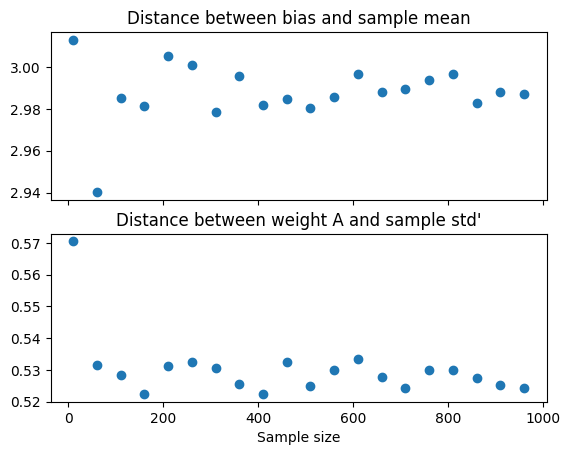

In [89]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, estimated_b_avg)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean") #Pas très lisible ...
axs[1].scatter(sample_sizes, estimated_A_avg)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")
plt.xlabel("Sample size")

## Effect of initialization

### Mean

In [90]:
learning_rate = 1e-3
distances = [x for x in range(20)]
time_to_conv = [] #nb of iter in the training loop
errors = [] #distance between the final estimation and the actual mean
for distance in distances: #Decreasing the quality of the initialization
    transformation = T(np.log(sigma_x), mu_x+distance, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0])))
    optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
    #Training
    stable_loss = False
    epsilon = 1e-4
    with torch.no_grad():
        previous_loss_test = transformation.L(X_test).mean().detach().item()
    time = n_iter
    for i in range(n_iter):
        #Computing train loss
        loss_train = transformation.L(X)
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if i%10 ==0: #We check the convergence every ten iterations
            with torch.no_grad():
                loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
            stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            time = i
            break
        previous_loss_test = loss_test
    time_to_conv.append(time)
    errors.append(torch.abs(transformation.b - torch.mean(X)).item())

Text(0.5, 1.0, "Distance between the final mean estimation VS distance between the initialization of the mean and the true value'")

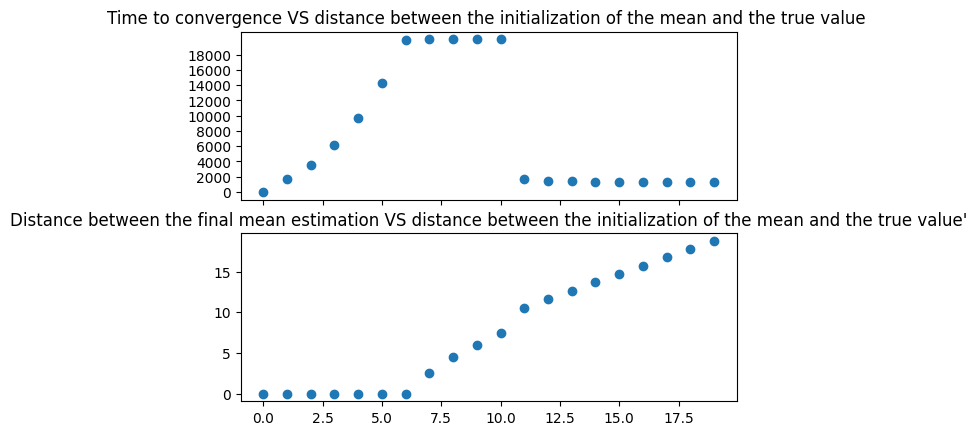

In [91]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(distances, time_to_conv)
axs[0].yaxis.set_ticks(np.arange(0,max(time_to_conv),2000))
axs[0].set_title("Time to convergence VS distance between the initialization of the mean and the true value ")
axs[1].scatter(distances, errors)
axs[1].set_title("Distance between the final mean estimation VS distance between the initialization of the mean and the true value'")


At first the time to convergence increases as the initialization gets further from the true value of mu.
Then, the time to convergence decreases but the estimation gets worse. The optimisation process gets 'stuck' on the way. __Maybe tuning the learning_rate would help__

### Standard deviation

In [92]:
n_iter = 5000
learning_rate = 1e-3
distances = [x for x in np.arange(0.1,5,0.2)]
time_to_conv = [] #nb of iter in the training loop
errors = [] #distance between the final estimation and the actual std
for distance in distances: #Decreasing the quality of the initialization
    transformation = T(np.log(sigma_x) + distance, mu_x, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0])))
    optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
    #Training
    stable_loss = False
    epsilon = 1e-4
    with torch.no_grad():
        previous_loss_test = transformation.L(X_test).mean().detach().item()
    time = n_iter
    for i in range(n_iter):
        #Computing train loss
        loss_train = transformation.L(X)
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if i%10 ==0: #We check the convergence every ten iterations
            with torch.no_grad():
                loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
            stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            time = i
            break
        previous_loss_test = loss_test
    time_to_conv.append(time)
    errors.append(torch.abs(torch.exp(transformation.alpha) - torch.std(X,unbiased=False)).item())

Text(0.5, 1.0, "Distance between the final std estimation VS distance between the initialization of alpha and the true value'")

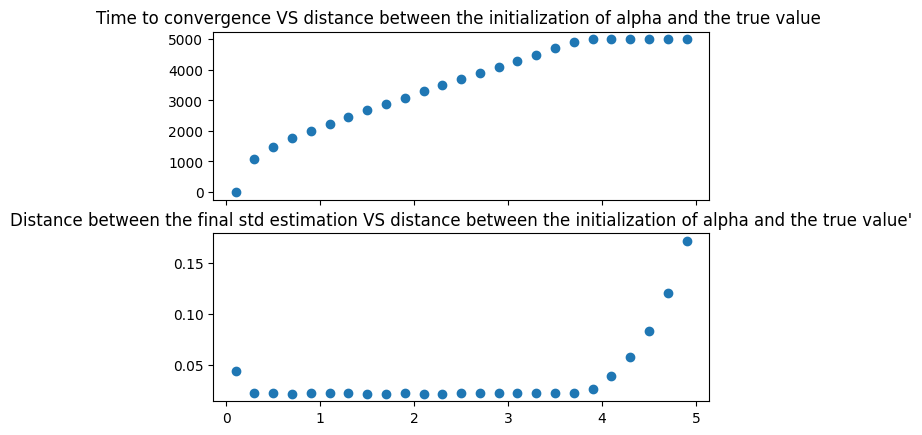

In [93]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(distances, time_to_conv)
#axs[0].yaxis.set_ticks(np.arange(0,max(time_to_conv),2000))
axs[0].set_title("Time to convergence VS distance between the initialization of alpha and the true value ")
axs[1].scatter(distances, errors)
axs[1].set_title("Distance between the final std estimation VS distance between the initialization of alpha and the true value'")


The time to convergence increases as the initialization gets further from the true value. For a distance to great the model has not the time to converge in 5000 iterations so the distance between the estimated parameter and the true value increases. (We can always increase the max number of iter)

## What if if X is not gaussian (here chi2)

In [94]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [95]:
transformation2 = T( 1, 1, torch.distributions.Normal(torch.Tensor([0.0]),torch.Tensor([1.0]))) #Instanciation
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [96]:
n_iter = 2000
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [97]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 1.9170793294906616 and b_hat =  1.294713020324707
 Sample std = 1.9814753532409668 and A_hat =  2.1112060546875
 Final loss =  2.1496684551239014


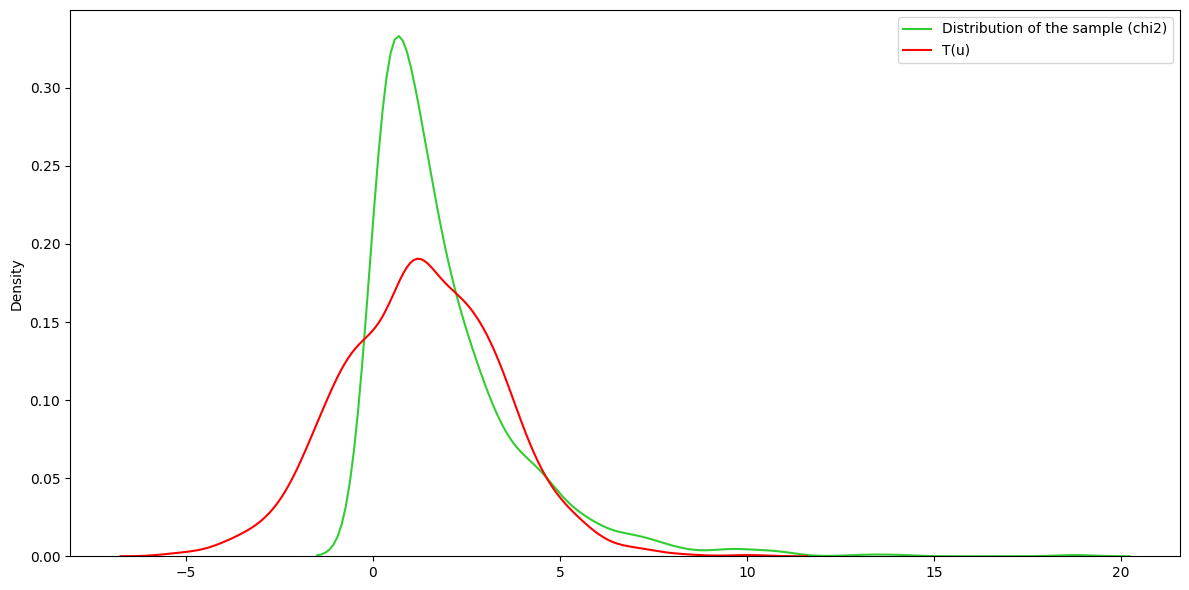

In [98]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample (chi2)', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U)[0].detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()

# Planar Flow ?

Trying to use a Sylvester flow, that is several planar flows. A Sylvester flow with $M$ hidden units can be represented as
$$ \boldsymbol{z'} = \boldsymbol{V}\sigma (\boldsymbol{W}^{T}\boldsymbol{z} + \boldsymbol{b} )$$
where $z$ is $D$ dimensional, $\boldsymbol{V}\in \mathbb{R}^{D\times M},\ \boldsymbol{M}\in \mathbb{R}^{D\times M},\ \boldsymbol{b}\in \mathbb{R}^{M} $
Here we use $\sigma = tanh$

In [99]:
X = gen_observations(N)
X_test = gen_observations(N)

In [100]:
class Sylvester(nn.Module):
    
    def __init__(self,prior, M): 
        #! How to ensure W.T . V > -(supx[sigma'(x)])^(-1)
        #! + is it useful since we do not use the inverse?
        """Instanciate the object to perform the transformation 
            z' = z + V tanh(W.T z + b)

        Args:
            prior (torch.distributio ): The base distribution
            M (int): Number of hidden units
        """
        super().__init__()
        self.M = M
        self.V = nn.Parameter(torch.Tensor(1, M)) #D = 1
        self.W = nn.Parameter(torch.Tensor(1, M)) #D = 1
        self.b = nn.Parameter(torch.Tensor(1, M)) #D = 1
        self.activation_function = torch.tanh
        self.prior = prior
        
        
        nn.init.uniform_(self.V, -1/np.sqrt(M), 1/np.sqrt(M))
        nn.init.uniform_(self.W, -1/np.sqrt(M), 1/np.sqrt(M))
        nn.init.uniform_(self.b, -1/np.sqrt(M), 1/np.sqrt(M))
        
        
        
    def forward(self, z):
        """Perform the transformation z' = z + V tanh(W.T z + b)
            and compute the log(det) using detJ=det(Id + S(z)W.T V), S(z)=diag( tanh'(W.Tz + b))

        Args:
            z (torch.Tensor)

        Returns:
            Tuple: z', log(det_J)
        """
        z_prime = torch.zeros_like(z)
        det = 0
        for i in range(z.shape[0]):
            fct_argument = torch.matmul(self.W.T, z[i].unsqueeze(-1)).squeeze() + self.b #arg of tanh
            activation = self.activation_function(fct_argument)
            z_prime[i] = z[i] + torch.matmul(self.V, activation.T)
            
            #Computing the det, but not using the decomposition since it requires M <= D = 1 ... 
            S = torch.diag(( 1 - activation**2 ).squeeze())
            det += torch.det( torch.eye(self.M) + torch.matmul(S, torch.matmul(self.W.T, self.V))) 
            return z_prime, torch.log(torch.abs(det))

    def loss(self, x):
        #Does not work proprely ...
        #Choosing this flow was maybe not a good idea since it cannot be inverted analytically ?
        #But the reverse div is supposed to work nevertheless
        U = self.sample(x.size())
        z,logdet = self.forward(x)
        log_pu = prior.log_prob(U)
        logpx = torch.distributions.Normal(torch.Tensor([mu_x]), torch.Tensor([sigma_x])).log_prob(self.forward(U)[0])
        res = log_pu - logdet - logpx
        return res.mean()
    
    def sample(self, size):
        """Sample using z' = Sylverster(u) ; u ~ N(0; 1)

        Args:
            size (Tuple): Size of the desired sample

        Returns:
            torch.Tensor
        """
        U = prior.sample(size)
        z, logdet_J = self.forward(U)
        return z

In [106]:
flows  = Sylvester(prior, 8)
learning_rate = 1e-3
optimizer = torch.optim.Adam(flows.parameters(), learning_rate)
n_iter = 2000
dataset = TensorDataset(X)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [107]:
# Keeping records of these values for later visualisations
losses_train = []
stable_loss = False
epsilon = 1e-5 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = flows.loss(X_test).mean().detach().item()
    
for i in range(n_iter):
    for j, batch in enumerate(dataloader):
    
        #Computing train loss
        loss_train = flows.loss(batch[0])
        losses_train.append(loss_train.detach().item())
        
        #Optimizaton steps
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    if i%50 == 0:
        print(f"Iter {i}, loss = {loss_train}")
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = flows.loss(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Iter 0, loss = 17.032114028930664
Iter 50, loss = 14.772993087768555
Iter 100, loss = 15.007081031799316
Iter 150, loss = 14.633430480957031
Iter 200, loss = 14.746522903442383
Iter 250, loss = 14.210996627807617
Iter 300, loss = 14.194719314575195
Iter 350, loss = 14.779685974121094
Iter 400, loss = 13.974518775939941
Iter 450, loss = 13.71726131439209
Iter 500, loss = 13.687982559204102
Iter 550, loss = 13.496731758117676
Iter 600, loss = 13.234535217285156
Iter 650, loss = 13.438541412353516
Iter 700, loss = 13.165576934814453
Iter 750, loss = 13.257319450378418
Iter 800, loss = 13.502963066101074
Iter 850, loss = 12.869856834411621
Iter 900, loss = 12.524358749389648
Iter 950, loss = 12.799426078796387
Iter 1000, loss = 12.970054626464844
Iter 1050, loss = 17.443017959594727
Iter 1100, loss = 13.647346496582031
Iter 1150, loss = 12.740117073059082
Iter 1200, loss = 13.947068214416504
Iter 1250, loss = 13.307114601135254
Iter 1300, loss = 12.53303337097168
Iter 1350, loss = 12.48282

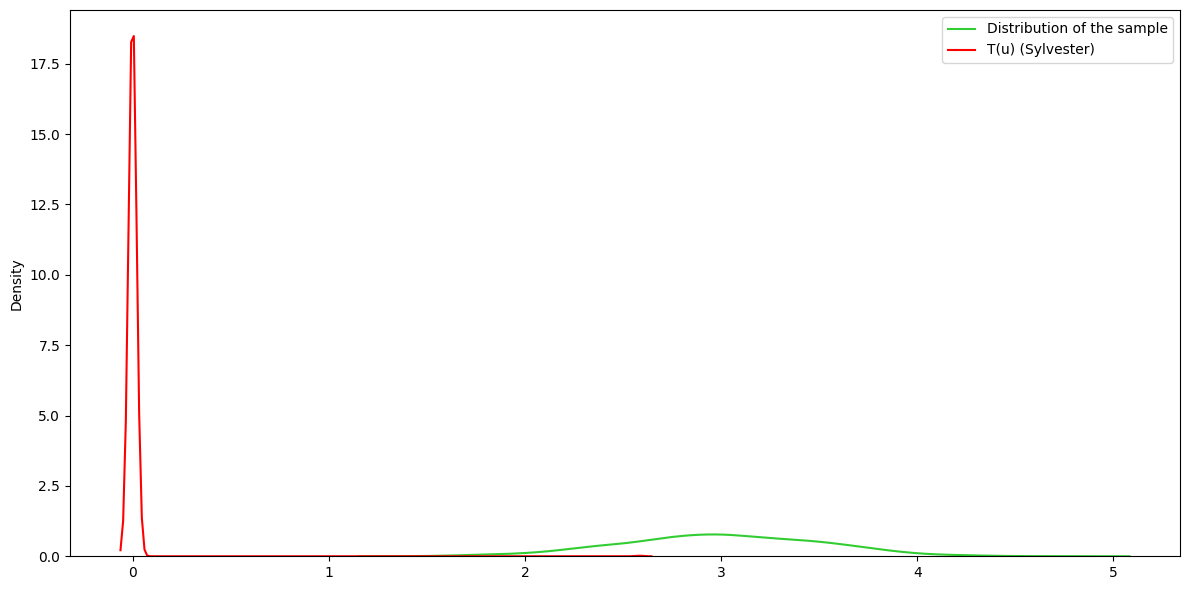

In [108]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= flows.forward(U)[0].detach().squeeze(), ax = ax, color='red', label='T(u) (Sylvester)')
ax.legend()
plt.tight_layout()
plt.show()